In [116]:
#!pip install lightgbm

In [117]:
#LIBRARIES

import time
start_time = time.time()

#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import itertools
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [118]:
pd.set_option('display.max_columns', 10)

In [119]:
#DATASETS
X_train = pd.read_csv('X_train.csv',sep=';',decimal=',')
forecast_df = pd.read_csv('X_test.csv',sep=';',decimal=',')
Y_test = pd.read_csv('Y_test.csv',sep=';',decimal=',')
Y_train = pd.read_csv('Y_train.csv',sep=';',decimal=',')

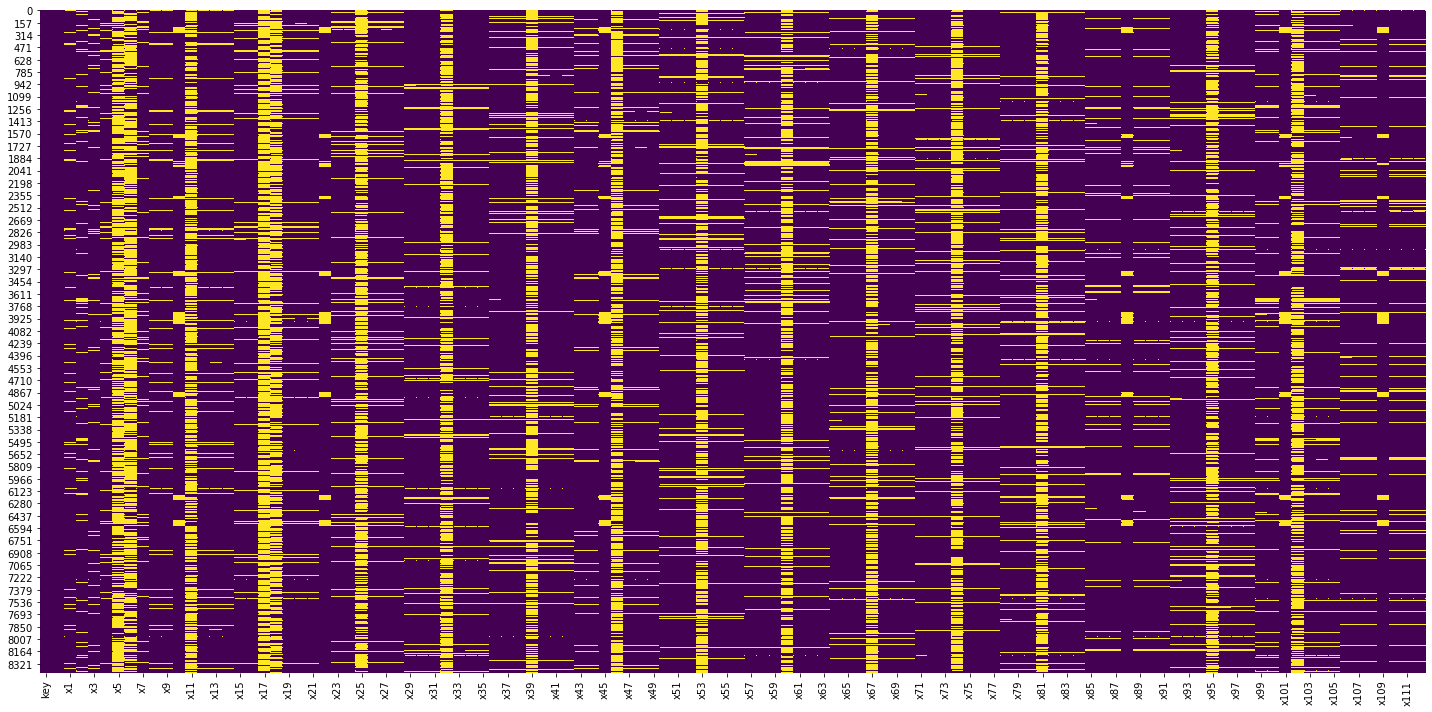

In [120]:
#VISUALIZATION OF MISSING VARIABLES

plt.figure(figsize=(20,10))
sns.heatmap(X_train.isna(),cbar=False,cmap='viridis')
plt.tight_layout()

In [121]:
pd.DataFrame((X_train.isna().sum()/8437)*100,columns=['missing_%'])

,missing_%
key,0.000000
date,0.000000
x1,7.550077
x2,7.633045
x3,7.585635
...,...
x108,7.348584
x109,7.490814
x110,7.313026
x111,7.348584


In [122]:
missing_df = pd.DataFrame((X_train.isna().sum()/8437)*100,columns=['missing_%'])

In [123]:
#IF VARIABLE HAS 25%> OF MISSING VALUES THAN X=1 , ELSE X=0
x = []
for i,item in missing_df.iterrows():
    if missing_df['missing_%'][i] >= 25:
        x.append(1)
    else:
        x.append(0)

In [124]:
#DATA PROCESSING; TAKING ONLY VARIABLES WHICH HAVE 25%> 
x = pd.DataFrame(x)
x = x.reset_index()

missing_df = missing_df.reset_index().reset_index()
missing_df = missing_df.rename(columns={'level_0':'index_2'})

x = x.rename(columns={'index':'index_2'})

new_missing = missing_df.merge(x,on='index_2')
new_missing = new_missing.drop(labels='index_2',axis=1)
new_missing = new_missing.rename(columns={0:'big'})

big_missing = new_missing[new_missing['big'] == 1 ]

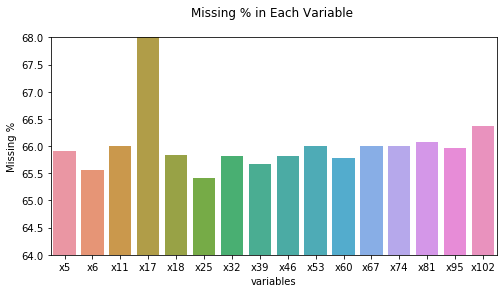

Note: that x17 has 75%> missing


In [125]:
#VISUALIZATION OF UPPER DATA PROCESSING; ALL VARIABLES WHICH HAVE >25% MISSING DATA ARE PRESENTED ON THE CHART, ALL OF THEM HAVE EVEN 60%> OF MISSING DATA WHICH IS TOO MUCH
plt.figure(figsize=(8,4))
sns.barplot(data=big_missing,x='index',y='missing_%')
plt.ylim((64,68))
plt.title('Missing % in Each Variable \n')
plt.xlabel('variables')
plt.ylabel('Missing %')
plt.show()
print('Note: that x17 has 75%> missing')

In [126]:
#DROPPING ALL THE VARIABLES BECAUSE ALL OF THEM HAVE >64% MISSING DATA 
X_train = X_train.drop(labels=["x5","x6","x11","x17","x18","x25","x32","x39","x46","x53","x60","x67"
                          ,"x74","x81","x95","x102"],axis=1)


#X_test = X_test.drop(labels=["x5","x6","x11","x17","x18","x25","x32","x39","x46","x53","x60","x67"
                       #   ,"x74","x81","x95","x102"],axis=1)

In [127]:
################################## END OF MISSING VARIABLES ####################################

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A66D9778C8>]],
      dtype=object)

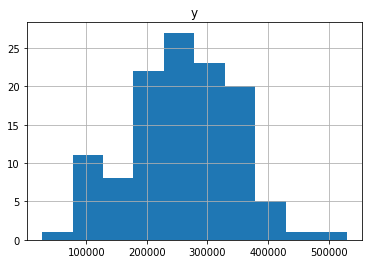

In [128]:
#STARTING TO CREATE THE CUSTOM METHOD OF IMPUTING THE REST OF MISSING DATA
Y_train.groupby('key').sum().hist()

In [129]:
Y_train.groupby('key').sum().describe()

,y
count,119.000000
mean,256959.107246
std,86251.155060
min,27132.286640
25%,211112.718249
50%,256603.403155
75%,312621.330262
max,529516.124969


In [130]:
df = Y_train.groupby('key').sum()
df

,y
key,
683,206887.040721
894,212196.123194
2831,301246.523222
2835,360693.260697
4361,376849.859478
...,...
96037,211968.251959
97021,347668.677305
97392,329822.768407


In [131]:
#CREATING CATEGORICAL VARIABLE ACCORDING TO SUMMED PRODUCITON FOR EACH KEY, LATER I WILL IMPUT THE MISSING DATA BASED ON overall size OF THE PRODUCT
x = []
for i,item in df.iterrows():
    if df['y'][i] <= 211112.718249:
        x.append(1)
    elif df['y'][i] > 211112.718249 and df['y'][i] <= 256603.403155:
        x.append(2)
    elif df['y'][i] > 256603.403155 and df['y'][i] <= 312621.330262:
        x.append(3) 
    elif df['y'][i] > 312621.330262:
        x.append(4)

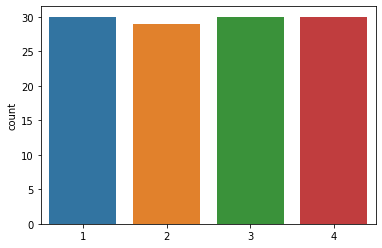

In [132]:
sns.countplot(x)

In [133]:
x = pd.DataFrame(x)
x = x.reset_index()

In [134]:
df = df.reset_index().reset_index()
df = df.merge(x,on='index').rename(columns={0:'Size_category'})
df = df[['key','Size_category']]

In [135]:
df_2 = df.copy()

In [136]:
X_train = X_train.merge(df,on='key')

In [137]:
#X_test = X_test.merge(df,on='key')

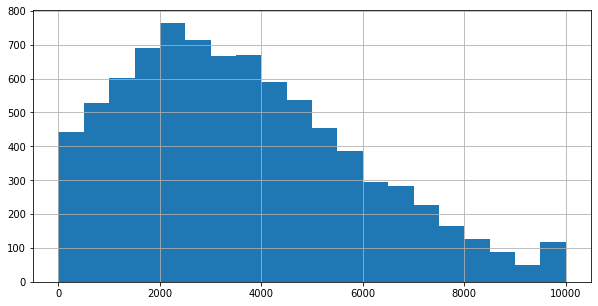

In [138]:
Y_train['y'].hist(bins=20,figsize=(10,5))

In [139]:
X_train['date'] = pd.to_datetime(X_train['date'])
X_train['month'] = pd.DatetimeIndex(X_train['date']).month
X_train['year'] = pd.DatetimeIndex(X_train['date']).year

#X_test['date'] = pd.to_datetime(X_test['date'])
#X_test['month'] = pd.DatetimeIndex(X_test['date']).month
#X_test['year'] = pd.DatetimeIndex(X_test['date']).year

Y_train['date'] = pd.to_datetime(Y_train['date'])
Y_train['month'] = pd.DatetimeIndex(Y_train['date']).month
Y_train['year'] = pd.DatetimeIndex(Y_train['date']).year

In [140]:
X_train['year'].value_counts()

2017    1428
2016    1427
2015    1396
2014    1284
2013    1264
2012     924
2018     714
Name: year, dtype: int64

In [141]:
x = []
for i,item in X_train.iterrows():
    if X_train['year'][i] == 2012:
        x.append(0)
    elif X_train['year'][i] == 2013:
        x.append(12)
    elif X_train['year'][i] == 2014:
        x.append(24)
    elif X_train['year'][i] == 2015:
        x.append(36)
    elif X_train['year'][i] == 2016:
        x.append(48)   
    elif X_train['year'][i] == 2017:
        x.append(60)
    elif X_train['year'][i] == 2018:
        x.append(72)
    elif X_train['year'][i] == 2019:
        x.append(84)    
        
X_train['add'] = x
X_train['new_month'] = X_train['month'] + X_train['add']
X_train = X_train.drop(labels=['month','year','add','date'],axis=1)


In [142]:
X_train = X_train.groupby('Size_category').transform(lambda x: x.fillna(x.mean()))

In [143]:
#x = []
#for i,item in X_test.iterrows():
#    if X_test['year'][i] == 2012:
#        x.append(0)
#    elif X_test['year'][i] == 2013:
#        x.append(12)
#    elif X_test['year'][i] == 2014:
#        x.append(24)
#    elif X_test['year'][i] == 2015:
#        x.append(36)
#    elif X_test['year'][i] == 2016:
#        x.append(48)   
#    elif X_test['year'][i] == 2017:
#        x.append(60)
#    elif X_test['year'][i] == 2018:
#        x.append(72)
#    elif X_test['year'][i] == 2019:
#        x.append(84)
#        
#X_test['add'] = x
#X_test['new_month'] = X_test['month'] + X_test['add']
#X_test = X_test.drop(labels=['month','year','add','date'],axis=1)

In [144]:
#X_test = X_test.groupby('Size_category').transform(lambda x: x.fillna(x.mean()))

In [145]:
x = []
for i,item in Y_train.iterrows():
    if Y_train['year'][i] == 2012:
        x.append(0)
    elif Y_train['year'][i] == 2013:
        x.append(12)
    elif Y_train['year'][i] == 2014:
        x.append(24)
    elif Y_train['year'][i] == 2015:
        x.append(36)
    elif Y_train['year'][i] == 2016:
        x.append(48)   
    elif Y_train['year'][i] == 2017:
        x.append(60)
    elif Y_train['year'][i] == 2018:
        x.append(72)
    elif Y_train['year'][i] == 2019:
        x.append(84)    
        
Y_train['add'] = x
Y_train['new_month'] = Y_train['month'] + Y_train['add']
Y_train =  Y_train.fillna(Y_train.mean())
Y_train = Y_train[['key','y','new_month']]

In [146]:
Y_train['key'].value_counts()

8200     78
99444    78
61127    78
57423    78
37081    78
         ..
93876    42
66606    42
24248    34
59945    30
74523    29
Name: key, Length: 119, dtype: int64

In [147]:
def TimeSeries(key=683):
    """ Wizualizacja szeregów czasowych dla wybranych produktów (key)"""
    Y_train[Y_train['key']==key].plot(kind='line',x='new_month',y='y',figsize=(12,6))

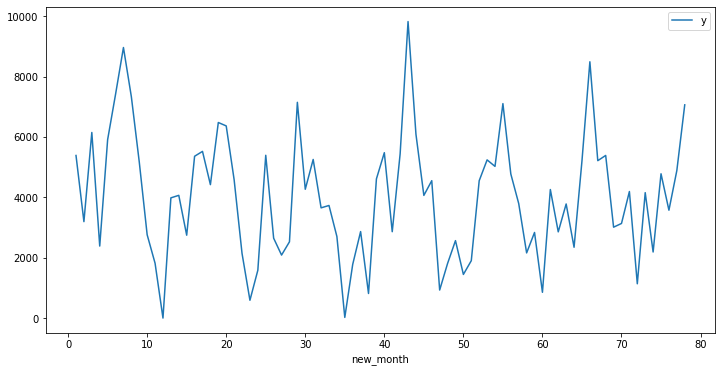

In [148]:
TimeSeries(8200)

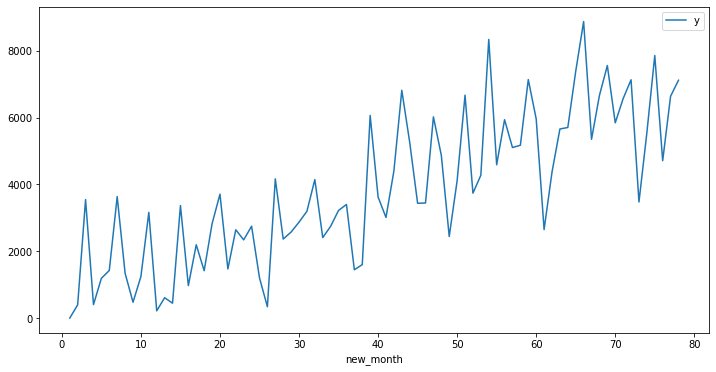

In [149]:
TimeSeries(99444)

In [150]:
train = X_train.merge(Y_train)

In [151]:
train['key'].nunique()

119

In [152]:
train

,key,x1,x2,x3,x4,...,x110,x111,x112,new_month,y
0,683,0.793085,0.000000,0.690346,0.000000,...,0.509713,216.851245,56.139906,1,1430.314968
1,683,0.000000,0.000686,0.590133,0.000000,...,2.526962,39.451960,7.172635,2,0.000000
2,683,0.000000,0.000000,0.000000,0.672651,...,0.242973,35.226264,50.614383,3,5088.531900
3,683,0.000000,0.000000,0.000000,0.022906,...,29.437773,5.591309,0.000000,4,2837.756051
4,683,0.000000,0.000000,0.000000,0.000000,...,0.125393,5.872891,0.000000,5,51.311689
...,...,...,...,...,...,...,...,...,...,...,...
8432,99444,0.000000,0.000000,0.000000,0.000000,...,-3.137605,1168.589213,64.490601,74,5543.532949
8433,99444,0.000000,0.000000,0.000000,0.000000,...,112.819870,541.409571,15.189098,75,7854.693921
8434,99444,1.205455,0.000000,6.719704,0.000000,...,1.532836,289.112965,1.863955,76,4707.540862
8435,99444,0.000000,0.000000,0.329129,0.000000,...,8.136763,6.391709,6.154658,77,6636.014977


In [153]:
scaler = StandardScaler()
train_st = scaler.fit_transform(train.drop(labels=['key','new_month','y'],axis=1))


In [154]:
train_st

array([[ 0.2391502 , -0.18767311,  0.21061112, ..., -0.20768281,
        -0.20066996,  0.91228334],
       [-0.18674309, -0.18731001,  0.15363245, ..., -0.19841295,
        -0.35030259, -0.1234781 ],
       [-0.18674309, -0.18767311, -0.18190199, ..., -0.20890856,
        -0.35386688,  0.79540683],
       ...,
       [ 0.46059616, -0.18767311,  3.63875046, ..., -0.20298125,
        -0.13971869, -0.23576792],
       [-0.18674309, -0.18767311,  0.00523264, ..., -0.17263426,
        -0.37818823, -0.14501047],
       [-0.18674309, -0.18767311, -0.18190199, ...,  0.02132138,
        -0.19367859, -0.23775597]])

In [155]:
train_st = pd.DataFrame(train_st, columns=train.drop(labels=['key','new_month','y'],axis=1).columns)

In [156]:
train_st

,x1,x2,x3,x4,x7,...,x108,x109,x110,x111,x112
0,0.239150,-0.187673,0.210611,-0.172746,-0.165245,...,-0.213418,-0.175389,-0.207683,-0.200670,0.912283
1,-0.186743,-0.187310,0.153632,-0.172746,-0.323753,...,-0.213418,-0.190182,-0.198413,-0.350303,-0.123478
2,-0.186743,-0.187673,-0.181902,0.172482,-0.025916,...,-0.213418,-0.197593,-0.208909,-0.353867,0.795407
3,-0.186743,-0.187673,-0.181902,-0.160990,-0.295025,...,-0.213418,-0.182639,-0.074750,-0.378863,-0.275195
4,-0.186743,-0.187673,-0.181902,-0.172746,1.535326,...,-0.213418,-0.193782,-0.209449,-0.378626,-0.275195
...,...,...,...,...,...,...,...,...,...,...,...
8432,-0.186743,-0.187673,-0.181902,-0.172746,-0.328209,...,-0.213418,0.087036,-0.224443,0.602101,1.088918
8433,-0.186743,-0.187673,-0.181902,-0.172746,0.260939,...,-0.124604,-0.432422,0.308416,0.073088,0.046087
8434,0.460596,-0.187673,3.638750,-0.172746,-0.206253,...,0.079784,0.219826,-0.202981,-0.139719,-0.235768
8435,-0.186743,-0.187673,0.005233,-0.172746,-0.310102,...,-0.213418,-0.547306,-0.172634,-0.378188,-0.145010


In [157]:
#PCA
#pca = PCA(n_components=10)

In [158]:
#columns = train.drop(labels=['key','new_month','y'],axis=1).columns

In [159]:
#principalComponents = pca.fit(train_st)

In [160]:
#principalComponents.explained_variance_ratio_

In [161]:
#np.cumsum(principalComponents.explained_variance_ratio_)

In [162]:
#principalComponents = pca.fit_transform(train_st)

In [163]:
#principalDf = pd.DataFrame(data = principalComponents)

In [164]:
#principalDf

In [165]:
#train = pd.concat([train[['key','new_month','y']], principalDf], axis = 1)

In [166]:
#train = train.fillna(train.mean())

In [167]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(labels='y',axis=1), train['y'],
                                                    test_size=0.3, random_state=101)

In [168]:
#mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=101)

In [169]:
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)

In [170]:
mdl.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [171]:
predictions = mdl.predict(X_test)

In [172]:
mean_squared_error(y_test,predictions)

2899525.664078799

In [173]:
r2_score(y_test,predictions)

0.44197655880999653

In [174]:
def WMAPE():
    return (sum(abs(y_test-predictions))/sum(y_test))*100

In [175]:
print('Model WMAPE error is:',round(WMAPE(),4))

Model WMAPE error is: 37.2325


In [176]:
#Tunning some parametrs of Random Forest classifier
param_grid = { 
    'n_estimators': [10,100,200,300,400,500,1000],
    'boosting_type': ['gbdt', 'dart', 'goss','rf'],
    'learning_rate' :[0.001,0.01,0.1],
    'num_leaves': [10,20,30,31,40,50,60]
}

In [177]:
#CV_rfc = GridSearchCV(estimator=mdl, param_grid=param_grid, cv= 5)

In [178]:
#CV_rfc.fit(X_train, y_train)

In [179]:
#CV_rfc.best_params_
#{'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500}

In [180]:
mdl = LGBMRegressor(boosting_type='dart',n_estimators=400, learning_rate=0.1,num_leaves=32)

In [181]:
mdl.fit(X_train,y_train)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=400, n_jobs=-1, num_leaves=32, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [182]:
predictions = mdl.predict(X_test)

In [183]:
mean_squared_error(y_test,predictions)

2753823.6202410203

In [184]:
r2_score(y_test,predictions)

0.47001740593821306

In [185]:
print('Model WMAPE error is:',round(WMAPE(),4))

Model WMAPE error is: 35.8851


In [186]:
print("My program took", time.time() - start_time, "to run.")

My program took 17.933248043060303 to run.


In [187]:
#FORECAST

In [188]:
forecast_df

,key,date,x1,x2,x3,...,x108,x109,x110,x111,x112
0,683,01Jul2018,0.000000,0.000000,0.397238,...,0.000000,39.599762,7.289597,2895.006107,48.666357
1,683,01Aug2018,NaN,0.000000,0.000000,...,0.357027,33.098055,17.244210,97.633777,3.189301
2,683,01Sep2018,0.000000,0.000000,0.000000,...,NaN,8.638553,NaN,NaN,NaN
3,683,01Oct2018,1.532104,0.576041,0.000000,...,0.000000,14.646718,2.719439,48.866957,0.267833
4,683,01Nov2018,0.000000,0.000000,0.000000,...,0.000000,-7.336147,2.190175,43.717736,0.833723
...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,01Feb2019,0.167286,0.000000,0.000000,...,0.000000,52.082725,0.764603,52.860076,0.262702
1424,99444,01Mar2019,0.000000,0.000000,0.000000,...,0.000000,142.196722,0.356890,6.263746,0.000000
1425,99444,01Apr2019,0.317642,0.000000,0.000000,...,0.000000,165.414227,0.038380,0.128338,0.073461
1426,99444,01May2019,0.000000,0.000000,0.677903,...,0.026931,58.296873,3.361134,3.618718,0.000000


In [189]:
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df['month'] = pd.DatetimeIndex(forecast_df['date']).month
forecast_df['year'] = pd.DatetimeIndex(forecast_df['date']).year

In [190]:
x = []
for i,item in forecast_df.iterrows():
    if forecast_df['year'][i] == 2012:
        x.append(0)
    elif forecast_df['year'][i] == 2013:
        x.append(12)
    elif forecast_df['year'][i] == 2014:
        x.append(24)
    elif forecast_df['year'][i] == 2015:
        x.append(36)
    elif forecast_df['year'][i] == 2016:
        x.append(48)   
    elif forecast_df['year'][i] == 2017:
        x.append(60)
    elif forecast_df['year'][i] == 2018:
        x.append(72)
    elif forecast_df['year'][i] == 2019:
        x.append(84)    
        
forecast_df['add'] = x
forecast_df['new_month'] = forecast_df['month'] + forecast_df['add']
forecast_df = forecast_df.drop(labels=['month','year','add','date'],axis=1)

In [191]:
forecast_df = forecast_df.drop(labels=["x5","x6","x11","x17","x18","x25","x32","x39","x46","x53","x60","x67"
                          ,"x74","x81","x95","x102"],axis=1)

In [192]:
forecast_df = forecast_df.merge(df_2,on='key')

In [193]:
forecast_df = forecast_df.groupby('Size_category').transform(lambda x: x.fillna(x.mean()))

In [194]:
forecast_df

,key,x1,x2,x3,x4,...,x109,x110,x111,x112,new_month
0,683,0.000000,0.000000,0.397238,0.000000,...,39.599762,7.289597,2895.006107,48.666357,79
1,683,0.528643,0.000000,0.000000,0.000000,...,33.098055,17.244210,97.633777,3.189301,80
2,683,0.000000,0.000000,0.000000,0.000000,...,8.638553,38.210813,346.673094,9.715094,81
3,683,1.532104,0.576041,0.000000,0.000000,...,14.646718,2.719439,48.866957,0.267833,82
4,683,0.000000,0.000000,0.000000,2.412814,...,-7.336147,2.190175,43.717736,0.833723,83
...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,0.167286,0.000000,0.000000,0.000000,...,52.082725,0.764603,52.860076,0.262702,86
1424,99444,0.000000,0.000000,0.000000,6.384198,...,142.196722,0.356890,6.263746,0.000000,87
1425,99444,0.317642,0.000000,0.000000,0.391461,...,165.414227,0.038380,0.128338,0.073461,88
1426,99444,0.000000,0.000000,0.677903,0.000000,...,58.296873,3.361134,3.618718,0.000000,89


In [195]:
predictions = mdl.predict(forecast_df)

In [199]:
y = pd.DataFrame(predictions).reset_index()

In [205]:
forecasted_df = forecast_df.reset_index().merge(y,on='index').rename(columns={0:'y'})

In [208]:
past = train[['key','new_month','y']]

In [209]:
future = forecasted_df[['key','new_month','y']]

In [210]:
past

,key,new_month,y
0,683,1,1430.314968
1,683,2,0.000000
2,683,3,5088.531900
3,683,4,2837.756051
4,683,5,51.311689
...,...,...,...
8432,99444,74,5543.532949
8433,99444,75,7854.693921
8434,99444,76,4707.540862
8435,99444,77,6636.014977


In [211]:
future

,key,new_month,y
0,683,79,6409.176023
1,683,80,5863.355788
2,683,81,5994.037335
3,683,82,6277.920102
4,683,83,6007.588138
...,...,...,...
1423,99444,86,6847.055786
1424,99444,87,7423.213702
1425,99444,88,7910.986796
1426,99444,89,6633.064824


In [238]:
max(past['new_month'])

78

In [239]:
max(future['new_month'])

90

In [252]:
future['key'].value_counts()

81879    12
39686    12
12851    12
74321    12
55896    12
         ..
87586    12
73255    12
75309    12
75315    12
77827    12
Name: key, Length: 119, dtype: int64

In [249]:
def Forecast(key=683):
    ax = past[past['key']==key].plot(x='new_month',y='y',label='observed',figsize=(14,7))
    future[future['key']==key].plot(ax=ax,x='new_month',y='y',label='forecast')
    plt.xlim(0,90)
    plt.title('Forecast vs Observed for product \n')

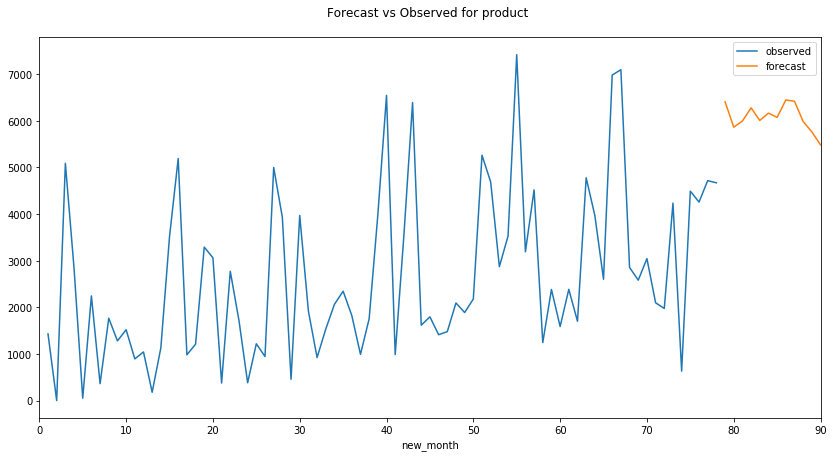

In [250]:
Forecast()

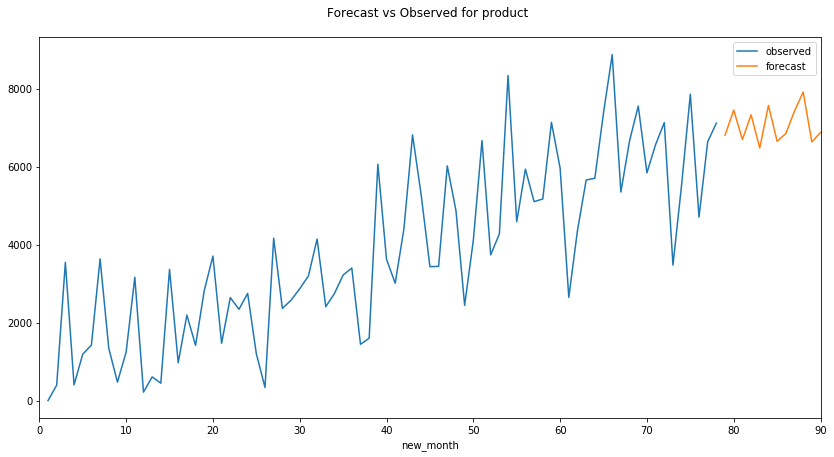

In [251]:
Forecast(99444)

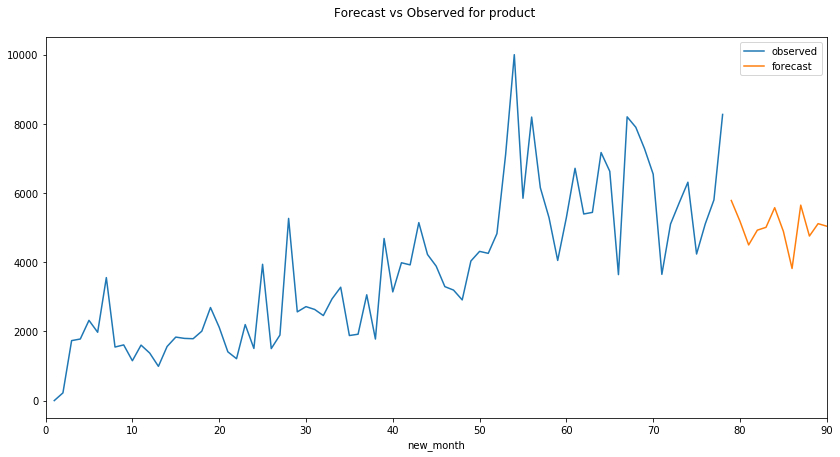

In [253]:
Forecast(74321)